In [7]:
# Basic imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn; sn.set(font_scale=1.2)
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {name: i for i, name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

# Training epochs
EPOCHS = 20

In [2]:
#Works with Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_data():
    datasets = [
        '/content/drive/My Drive/Colab Notebooks/Final Project/Deep Learning/seg_test',
        '/content/drive/My Drive/Colab Notebooks/Final Project/Deep Learning/seg_train'
    ]

    output = []

    for dataset in datasets:
        images = []
        labels = []
        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(dataset, folder, file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32') / 255.0  # normalize
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

In [5]:
# Load train and test data
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

print("Number of training examples:", train_labels.shape[0])
print("Number of testing examples:", test_labels.shape[0])
print("Each image size:", IMAGE_SIZE)

Loading /content/drive/My Drive/Colab Notebooks/Final Project/Deep Learning/seg_test


100%|██████████| 437/437 [00:07<00:00, 60.15it/s] 


Loading /content/drive/My Drive/Colab Notebooks/Final Project/Deep Learning/seg_train


100%|██████████| 2522/2522 [01:09<00:00, 36.14it/s] 
0it [00:00, ?it/s]


Number of training examples: 3000
Number of testing examples: 9870
Each image size: (150, 150)


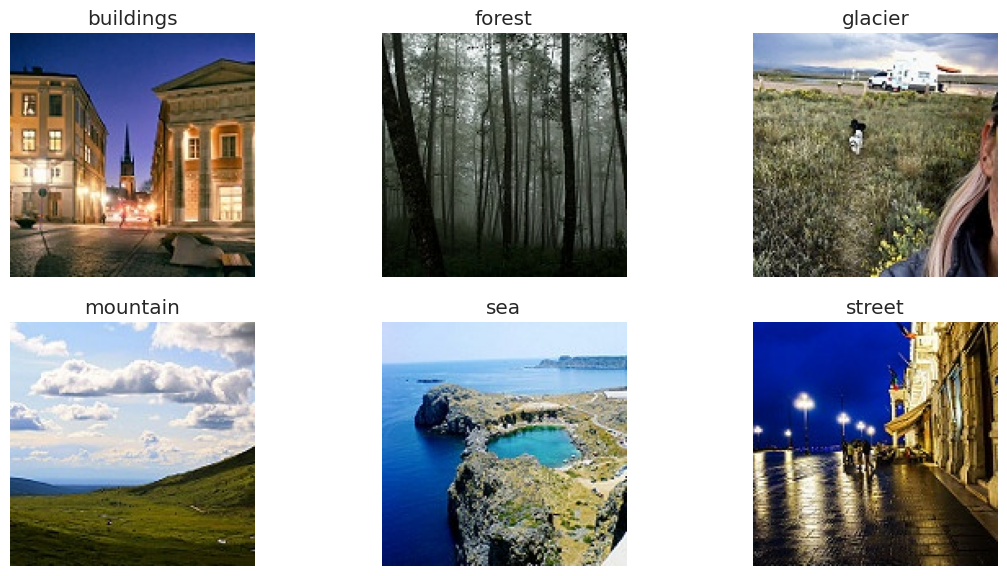

In [6]:
def display_random_image_per_class(class_names, images, labels):
    plt.figure(figsize=(12,6))

    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        index = np.random.choice(class_indices)
        plt.subplot(2, 3, i+1)
        plt.imshow(images[index])
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_random_image_per_class(class_names, train_images, train_labels)

In [9]:
#CNN Models
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(nb_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816,454 (26.00 MB)

 Trainable params: 6,815,494 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation='softmax')(x)

efficient_model = Model(inputs=base_model.input, outputs=predictions)

efficient_model.compile(optimizer=Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_images, train_labels,
    epochs=EPOCHS,
    validation_data=(test_images, test_labels),
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.4817 - loss: 2.0213 - val_accuracy: 0.0000e+00 - val_loss: 6.2239 - learning_rate: 1.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.7004 - loss: 0.8302 - val_accuracy: 0.0055 - val_loss: 7.8731 - learning_rate: 1.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.8097 - loss: 0.5325 - val_accuracy: 0.0048 - val_loss: 6.6826 - learning_rate: 1.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8780 - loss: 0.3704 - val_accuracy: 0.2867 - val_loss: 3.0927 - learning_rate: 1.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9056 - loss: 0.2734 - val_accuracy: 0.5768 - val_loss: 1.4416 - learning_rate: 1.0000e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9298 - loss: 0.2111 - val_accuracy: 0.7136 - val_loss: 0.8929 - learning_rate: 1.0000e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9

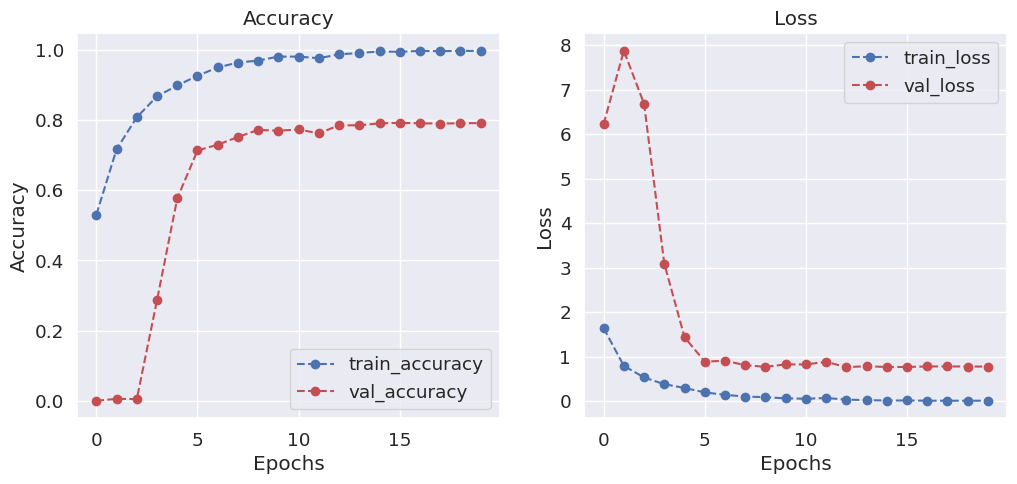

In [12]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], 'bo--', label="train_accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'bo--', label="train_loss")
    plt.plot(history.history['val_loss'], 'ro--', label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_accuracy_loss(history)

309/309 ━━━━━━━━━━━━━━━━━━━━ 99s 319ms/step


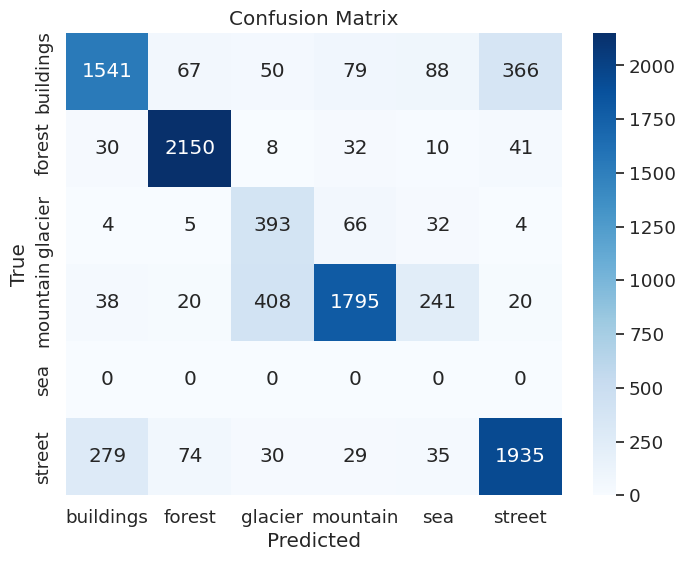

In [16]:
# Predict test images
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


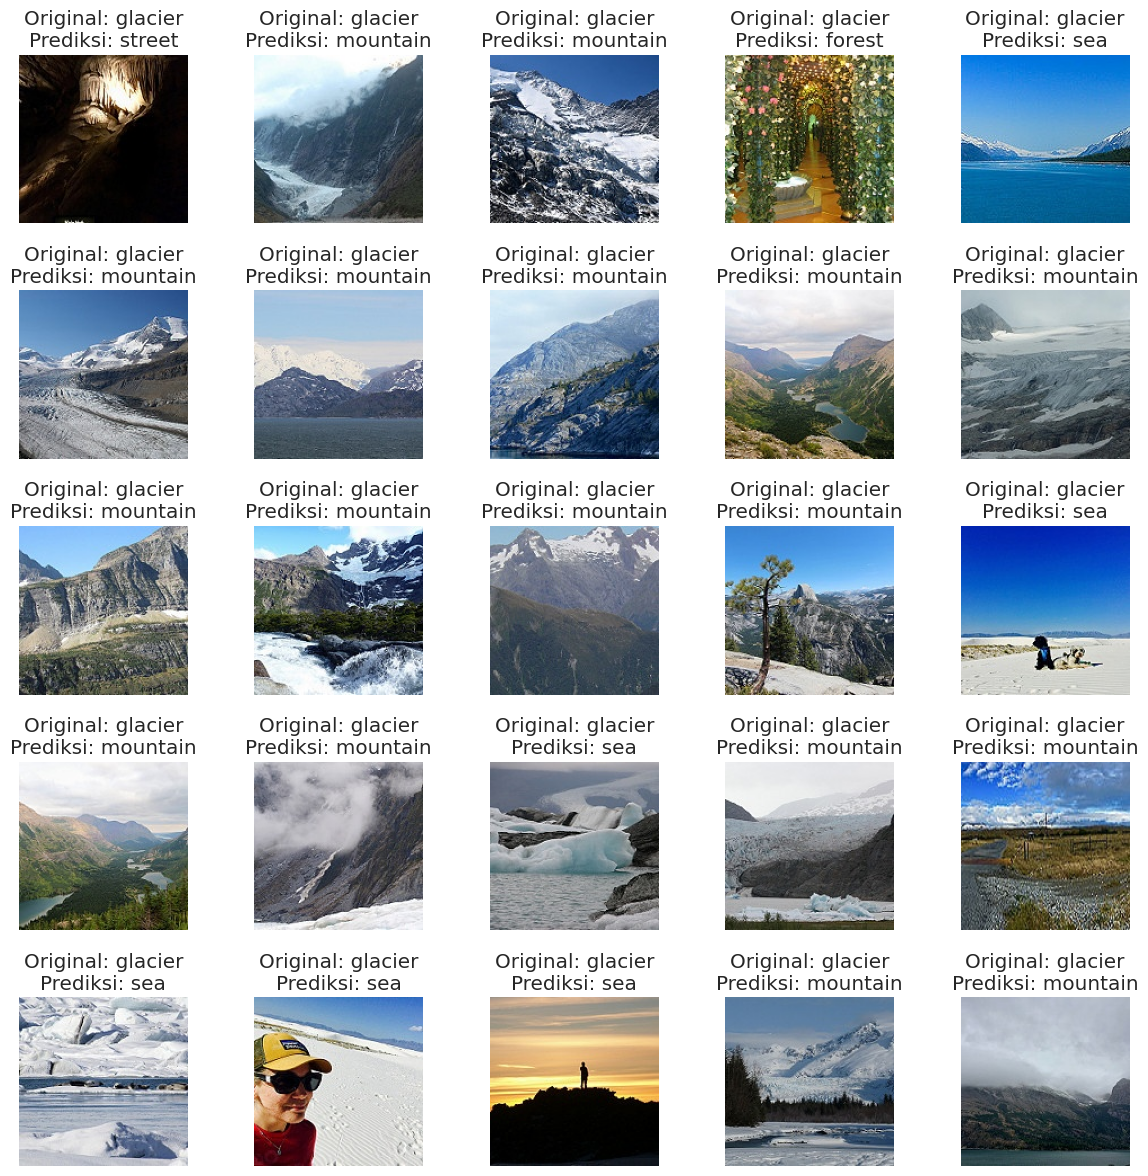

In [19]:
def display_mislabeled(class_names, images, true_labels, pred_labels, n=25):
    mislabeled_indices = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(12,12))
    for i in range(min(n, len(mislabeled_indices))):
        idx = mislabeled_indices[i]
        plt.subplot(5,5,i+1)
        plt.imshow(images[idx])
        plt.title(f"Original: {class_names[true_labels[idx]]}\nPrediksi: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_mislabeled(class_names, test_images, test_labels, y_pred_classes)